We aim to describe explicit embeddings based on the following situation.

**Input:** We choose 4 unit vectors of lengths 4.

**Output:** Two quantum circuits that map |0000> to the normalized sum of the chosen vectors. The first one is obtained via a specialized combinatorial method. The second uses the Möttönen embedding.

**Aim:** Demonstrate that our specialized method results in a much more efficient and shorter quantum circuit.

**Idea:** Leverage the relation between the vectors and appropriately apply Hadamard, NOT, CNOT and CCNOT gates.

In [79]:
# Install all relevant libraries
# !pip install qiskit
# !pip install qiskit_ibm_runtime
# !pip install pennylane
# !pip install qiskit_aer
# !pip install tqdm
# !pip install pandas

In [50]:
# Load the relevant packages
from qiskit import qasm2, QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, Batch
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.quantum_info import Statevector
from qiskit.visualization import latex
from qiskit_aer import AerSimulator
from qiskit.circuit.library import StatePreparation

import pennylane as qml
import numpy as np
import pandas as pd 
from tqdm import tqdm
from time import time
import pickle

In [51]:
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First we need some helper functions regarding matrices and integers

In [52]:
# Input: A natural number n
# Output: A list with elements all lists of length n with elements 0 and 1.
def inductive_list(n):
    result = [[]]
    for index in range(n):
        result = [[0] + step for step in result] + [[1] + step for step in result]
    return result

# Input: A list with elements 0 and 1
# Output: A boolean determining whether it is ordered, meaning all 1s are in lower indeces
def is_ordered_list(unordered_list):
    if 0 in unordered_list and 1 in unordered_list:
        return max([index for index in range(len(unordered_list)) if unordered_list[index] == 1]) < min([index for index in range(len(unordered_list)) if unordered_list[index] == 0])
    return True

# Input: A list consisting of 0 and 1
# Output: The value of the list considered as a binary number
def list_value(input_list):
    input_list = list(reversed(input_list))
    return sum([input_list[index] * 2 ** index for index in range(len(input_list))])

# Input: A list consisting of 0 and 1
# Output: The list of non-zero indeces
def non_zero_coordinates(vector):
    return [index for index in range(len(vector)) if vector[index] != 0]

# Input: A positive integer
# Output: A list with the binary representation normalized to total_length
def int_to_binary_list(num, total_length):
    return [int(char) for char in str(bin(num))[len(str(bin(num)))-1:1:-1]] + (total_length-len([int(char) for char in str(bin(num))[len(str(bin(num)))-1:1:-1]]))*[0]



We now explicitly describe the idea of the algorithm. We have four vectors, chosen from the 16 vectors
<center>
|0000>, |0100>, |1000>, |1100>, |0010>, |0110>, |1010>, |1110>,|0001>, |0101>, |1001>, |1101>, |0011>, |0111>, |1011>, |1111>.
</center>
The collection of four vectors can be depicted as a 4 by 4 matrix. Here each row of the matrix depicts one of the vectors we have chosen and each column of the matrix depicts a wire.


We now proceed as follows:
1. First we implement the following reduction step: If a column has more than two 1s or exactly two 1s with the top not being a 1, then revert the 1s and 0s and remember to apply a NOT gate at the end of the process.

2. Having applied these three reduction steps we are left with 47 remaining cases, up to reordering the wires, and in all of these cases there are two columns which have one of the following forms:

   a. |00> , |01>, |10>, |11>

   b. |00> , |00>, |01>, |10>

   c. |00> , |00>, |01>, |11>

   d. |00> , |00>, |10>, |11>

   We hence add two Hadamard gates to precisely those two wires.    

4. We then apply several CNOT and CCNOT gates to obtain the remaining 1s in the matrix.

5. If in Step 1. we were in Case b. or c. or d. we then turn the |11> or |10> or |01> into |00>

6. The resulting quantum gate will precisely map |0000> to the anticipated sum of the four vectors.


We start with the revelant function necessary for reducing via Not gates, corresponding to Step 1.

In [53]:
# Input: A matrix as a list of lists.
# Output: A list of 1s and 0s deciding which columns need a Not gate according to the rule stated above.
#         Additionally the matrix with the Not gates applied.
def decide_not_gates(matrix):
    flipped_matrix = matrix.copy()
    # Create a list with value 0 indexed by all wires.
    list_of_not_gates = [0 for _ in range(len(flipped_matrix[0]))]
    for index_two in range(len(flipped_matrix[0])):
        temp_sum = sum([flipped_matrix[index_one][index_two] for index_one in range(len(flipped_matrix))])
        # If there are more than two 1s or there are two 1s and the top row is not 0 we flip that column
        if temp_sum > 2 or (temp_sum == 2 and flipped_matrix[0][index_two] == 0):
            list_of_not_gates[index_two] = 1
            for index_one in range(len(flipped_matrix)):
                flipped_matrix[index_one][index_two] = flipped_matrix[index_one][index_two] ^ 1
    flipped_matrix.sort(key = list_value)
    flipped_matrix.reverse()
    #By reordering the wires, the top row might again have a zero and so we have to apply further flips of the columns.
    for index_two in range(len(flipped_matrix[0])):
        temp_sum = sum([flipped_matrix[index_one][index_two] for index_one in range(len(flipped_matrix))])
        if (temp_sum == 2 and flipped_matrix[0][index_two] == 0):
            if list_of_not_gates[index_two] == 1:
                list_of_not_gates[index_two] = 0
            else:
                list_of_not_gates[index_two] = 1
            for index_one in range(len(flipped_matrix)):
                flipped_matrix[index_one][index_two] = flipped_matrix[index_one][index_two] ^ 1
    return flipped_matrix, list_of_not_gates


Add explaination of algorithm using below test-case as an example

In [57]:
# ??
# Test cases:
matrix = [[1,0,1,1],[0,1,0,0],[1,0,0,1],[1,1,0,0]]
pd.DataFrame(matrix)

,0,1,2,3
0,1,0,1,1
1,0,1,0,0
2,1,0,0,1
3,1,1,0,0


In [58]:
flipped_matrix, list_of_not_gates = decide_not_gates(matrix)
pd.DataFrame(flipped_matrix)

,0,1,2,3
0,1,1,0,1
1,0,0,1,0
2,0,0,0,0
3,0,1,0,1


In [59]:
list_of_not_gates

[1, 0, 0, 1]

We continue with the needed functions to pick out the Hadamard gates, implementing Step 2.

In [60]:
# Input: Two lists, and a positive integer
# Output: A boolean, stating whether the number of indeces at which the two lists disagree is less than max_divergence.
def almost_equal(list_one,list_two,max_divergence = 1):
    counter = 0
    for row in list_one:
        if row not in list_two:
            counter += 1
    if counter <= max_divergence:
        return True
    else:
        return False

# Input: Two positive integers with m > n.
# Output: A list with elements lists of length m with all elements 0 and 1 with precisely n 1s.
def generate_sublists(m,n):
    return [test_list for test_list in inductive_list(m) if sum(test_list) == n]

# Input: A matrix given as a list of lists and a max_divergence set to 1 by default.
# Output: A list of two columns, which are used for the hadamard gate.
def pick_hadamard_gates(matrix,max_divergence = 1):
    m = len(matrix)
    column = 0
    #This just generates the simple list [[1,1],[1,0],[0,1],[0,0]]
    correct_list = list(reversed(inductive_list(m-2)))
    check_list = list(reversed(generate_sublists(m,len(correct_list[0]))))
    # We will go through all possible combinations of 2 columns and check whether they are close enough to the Hadamard rows
    # Those columns are chosen based on the following decreasing criteria:
    # 1. Two columns that precisely coincide
    # 2. Two columns that diverge at one row and have a [1,1]
    # 3. Two columns that diverge at one row and do not have [1,1]
    for divergence in range(max_divergence+1):
        for test in check_list:
            test_rows = [[matrix[index_one][index_two]  for index_two in range(len(matrix[0])) if test[index_two] == 1] for index_one in range(len(matrix))]
            if almost_equal(correct_list,test_rows,divergence) and ([1,1] in test_rows) and (divergence == 0 or len([row for row in test_rows if row == [0,0]]) == 2):
                return [index for index in range(len(test)) if test[index] == 1],divergence

    for divergence in range(1,max_divergence+1):
        for test in check_list:
            test_rows = [[matrix[index_one][index_two]  for index_two in range(len(matrix[0])) if test[index_two] == 1] for index_one in range(len(matrix))]
            if almost_equal(correct_list,test_rows,divergence) and (divergence == 0 or len([row for row in test_rows if row == [0,0]]) == 2):
                return [index for index in range(len(test)) if test[index] == 1],divergence

# Test cases:
# print(pick_hadamard_gates([[1,1,1,0],[1,0,0,0],[0,0,0,1],[0,0,0,0]]))
# print(pick_hadamard_gates([[1,1,0,0],[1,0,0,0],[0,0,1,0],[0,0,0,1]]))
# print(pick_hadamard_gates([[1,1,0,0],[1,0,0,0],[0,0,1,1],[0,0,0,0]]))
# print(pick_hadamard_gates([[1,1,0,0],[1,0,1,0],[0,0,0,1],[0,0,0,0]]))
# print(pick_hadamard_gates([[1,1,1,0],[1,1,0,0],[0,0,0,1],[0,0,0,0]]))
# print(pick_hadamard_gates([[1,0,1,0],[1,0,0,0],[0,1,0,0],[0,0,0,0]]))
# print(pick_hadamard_gates([[1,1,1,0],[1,0,0,0],[0,1,0,0],[0,0,0,0]]))

We now introduce two helper functions to for our main function.
1. A function adding CCX gates along with appropriately chosen Not gates.
2. A function removing additional Not gates from a circuit.

In [61]:
# Input:
# - circuit: A quantum circuit
# - qreg_q: A quantum register used in the quantum circuit
# - matrix: A list of lists
# - row: The row coordinate of the 1 that is the aim of the CCX gate
# - column: The column coordinate of the 1 that is the aim of the CCX gate
# - hadamard_wire_one: First wire used as the input of the CCX gate
# - hadamard_wire_two: Second wire used as the input of the CCX gate
# Output: The circuit with added CCX gate and, if necessary, some Not gates.
def include_targeted_one(circuit, qreg_q, matrix, row, column, hadamard_wire_one, hadamard_wire_two):
    # We check the coordiantes of the relevant row.
    # If there are zeroes we apply a Not gate for each 0.
    # We then apply the CCNot gate to turn the relevant coordinate into 1.
    # Finally, we apply the same Not gates to get the other wires into the original state.
    if matrix[row][hadamard_wire_one] == 0 and matrix[row][hadamard_wire_two] == 0:
        circuit.x(qreg_q[3 - hadamard_wire_one])
        circuit.x(qreg_q[3 - hadamard_wire_two])
        circuit.ccx(qreg_q[3 - hadamard_wire_one], qreg_q[3 - hadamard_wire_two], qreg_q[3 - column])
        circuit.x(qreg_q[3 - hadamard_wire_two])
        circuit.x(qreg_q[3 - hadamard_wire_one])
    elif matrix[row][hadamard_wire_one] == 1 and matrix[row][hadamard_wire_two] == 0:
        circuit.x(qreg_q[3 - hadamard_wire_two])
        circuit.ccx(qreg_q[3 - hadamard_wire_one], qreg_q[3 - hadamard_wire_two], qreg_q[3 - column])
        circuit.x(qreg_q[3 - hadamard_wire_two])
    elif matrix[row][hadamard_wire_one] == 0 and matrix[row][hadamard_wire_two] == 1:
        circuit.x(qreg_q[3 - hadamard_wire_one])
        circuit.ccx(qreg_q[3 - hadamard_wire_one], qreg_q[3 - hadamard_wire_two], qreg_q[3 - column])
        circuit.x(qreg_q[3 - hadamard_wire_one])
    else:
        circuit.ccx(qreg_q[3 - hadamard_wire_one], qreg_q[3 - hadamard_wire_two], qreg_q[3 - column])
    return circuit

# Input: Quantum circuit
# Output: Same circuit with extraneous Not gates removed
def remove_repetitive_nots(circuit):
    # Save number of wires in the circuit
    number_wires = circuit.num_qubits
    # Define a list with value -1 as long as the number of wires.
    # Anytime a Not gate is added to a wire, the value at that wire will change to the index of the Not gate in circuit.data.
    # If a second Not gate is added to that wire, both are removed from circuit.data
    # However, anytime any other gate is added in between, such as CNot gate or CCNot gate,
    # the values of all wires involves will be reset and so adding a new Not gate will not resolve in cancellation.
    current_status = [-1 for _ in range(number_wires)]
    # Index count the current gate being checked.
    index = 0
    while index < len(circuit.data):
        gate = circuit.data[index]
        # For Hadamard gates do nothing
        if gate[0].name == 'h':
            index += 1
        # For CNot gate reset the value of the two wires involved.
        elif gate[0].name == 'cx':
            current_status[gate[1][0]._index] = -1
            current_status[gate[1][1]._index] = -1
            index += 1
        # For CCNot gate reset the value of the three wires involved.
        elif gate[0].name == 'ccx':
            current_status[gate[1][0]._index] = -1
            current_status[gate[1][1]._index] = -1
            current_status[gate[1][2]._index] = -1
            index += 1
        # For a Not gate we have two cases.
        # The first case is if we are encountering the first Not gate past a reset.
        elif gate[0].name == 'x' and current_status[gate[1][0]._index] == -1:
            current_status[gate[1][0]._index] = index
            index += 1
        # The second case is if we are encountering a Not gate after a first Not gate.
        elif gate[0].name == 'x' and current_status[gate[1][0]._index] > -1:
            # We remove this Not gate and the one before as given by the saved index
            circuit.data.pop(index)
            circuit.data.pop(current_status[gate[1][0]._index])

            # If necessary we adjust the indeces of the other wires, effected by the removal.
            for index_four in range(len(current_status)):
                if current_status[index_four] > current_status[gate[1][0]._index]:
                    current_status[index_four] -= 1
            # We reset the this wire
            current_status[gate[1][0]._index] = -1
            # Move on to the next gate, but also reindex because we removed two gates.
            index -= 1
    return circuit

We are now ready to construct the quantum circuit, via two functions.
1. The first transforms a binary list into a matrix.
2. The second constructs a quantum circuit out of the matrix, which takes |0000> to the sum of the rows of the matrix.

In [65]:
# Input: A binary list consisting of 0s and 1s
# Output: A matrix as a list of lists, which is the input of the quantum circuit construction.
def binary_list_to_statevector(binary_list):
    # Convert the binary list to a binary string
    binary_string = ''.join(map(str, binary_list))

    # Convert the binary string to an integer index
    index = int(binary_string, 2)

    # Number of qubits is the length of the binary list
    num_qubits = len(binary_list)

    # Create an array of zeros with the appropriate size (2^num_qubits)
    statevector_array = [0.0] * (2**num_qubits)
    # statevector_array = numpy.zeros(2**num_qubits, dtype=complex)

    # Set the amplitude at the calculated index to 1
    statevector_array[index] = 1.0

    # Create the statevector from the array
    statevector = Statevector(statevector_array)

    return statevector

def embedding_two(matrix):
    #First we fix the matrix and remember which flips we need to apply at the end.
    new_matrix, list_of_not_gates = decide_not_gates(matrix)

    # Helper variables, picking out the wires where we apply the Hadamard gates, how they actually look like, and the remaining wires.
    hadamard_gate_wires = pick_hadamard_gates(new_matrix)[0]
    all_hadamard_rows = [[ new_matrix[row][wire] for wire in range(len(new_matrix[0])) if wire in hadamard_gate_wires] for row in range(len(new_matrix))]
    remaining_wires = [index for index in range(len(new_matrix[0])) if index not in hadamard_gate_wires]
    all_hadamard_rows = [[ new_matrix[row][wire] for wire in range(len(new_matrix[0])) if wire in hadamard_gate_wires] for row in range(len(new_matrix))]

    # If the columns chosen for the Hadamard gates do not coincide, meaning are not precisely [1,1], [1,0], [0,1], [0,0],
    # then we adjust the matrix appropriately and remember the changes we have made, as a code in flip_hadamard_row.
    flip_hadamard_row = 0
    if len([row for row in all_hadamard_rows if row == [0,0]]) == 2:
        # First case we have [1,0], [0,1], [0,0], [0,0]
        if [1,1] not in all_hadamard_rows:
            # We figure out which rows are [0,0]
            [first_zeros,second_zeros] = [index for index in range(len(new_matrix)) if all_hadamard_rows[index] == [0,0]]

            # We figure out which row is [1,0]
            [onezero] = [index for index in range(len(new_matrix)) if all_hadamard_rows[index] == [1,0]]

            # We figure out which row is [0,1]
            [zeroone] = [index for index in range(len(new_matrix)) if all_hadamard_rows[index] == [0,1]]

            # We rearrange the rows and adjust the values of of the matrix so that it matches what comes from two Hadamard gates
            new_matrix = [new_matrix[first_zeros]] + [new_matrix[onezero]] + [new_matrix[zeroone]] + [new_matrix[second_zeros]]
            temp_0, temp_1 = pick_hadamard_gates(new_matrix)[0][0], pick_hadamard_gates(new_matrix)[0][1]
            new_matrix[0][temp_0] = 1
            new_matrix[0][temp_1] = 1

            # We change the variable to adjust the circuit later on
            flip_hadamard_row = 1
        # Second case we have [1,1], [0,1], [0,0], [0,0]
        elif [1,0] not in all_hadamard_rows:
            # We figure out which rows are [0,0]
            [first_zeros,second_zeros] = [index for index in range(len(new_matrix)) if all_hadamard_rows[index] == [0,0]]

            # We figure out which row is [1,1]
            [oneone] = [index for index in range(len(new_matrix)) if all_hadamard_rows[index] == [1,1]]

            # We figure out which row is [0,1]
            [zeroone] = [index for index in range(len(new_matrix)) if all_hadamard_rows[index] == [0,1]]

            # We rearrange the rows and adjust the values of of the matrix so that it matches what comes from two Hadamard gates
            new_matrix = [new_matrix[oneone]] + [new_matrix[first_zeros]] + [new_matrix[zeroone]] + [new_matrix[second_zeros]]
            new_matrix[1][pick_hadamard_gates(new_matrix)[0][0]] = 1

            # We change the variable to adjust the circuit later on
            flip_hadamard_row = 2
        # Third case we have [1,1], [1,0], [0,0], [0,0]
        elif [0,1] not in all_hadamard_rows:
            # We figure out which rows are [0,0]
            [first_zeros,second_zeros] = [index for index in range(len(new_matrix)) if all_hadamard_rows[index] == [0,0]]

            # We figure out which row is [1,1]
            [oneone] = [index for index in range(len(new_matrix)) if all_hadamard_rows[index] == [1,1]]

            # We figure out which row is [1,0]
            [onezero] = [index for index in range(len(new_matrix)) if all_hadamard_rows[index] == [1,0]]

            # We rearrange the rows and adjust the values of of the matrix so that it matches what comes from two Hadamard gates
            new_matrix = [new_matrix[oneone]] + [new_matrix[onezero]] + [new_matrix[first_zeros]] + [new_matrix[second_zeros]]
            new_matrix[2][pick_hadamard_gates(new_matrix)[0][1]] = 1

            # We change the variable to adjust the circuit later on
            flip_hadamard_row = 3

    # Update helper variables.
    all_hadamard_rows = [[ new_matrix[row][wire] for wire in range(len(new_matrix[0])) if wire in hadamard_gate_wires] for row in range(len(new_matrix))]

    # We introduce the quantum register and the circuit based on it.
    qreg_q = QuantumRegister(4, 'q')
    circuit = QuantumCircuit(qreg_q)

    #Add Hadamard gates
    circuit.h(qreg_q[3 - hadamard_gate_wires[0]])
    circuit.h(qreg_q[3 - hadamard_gate_wires[1]])

    #Add all the ones in the two other wires via CNOT and CCNOT gates.
    for active_wire in remaining_wires:
        # Variables picking out the column we are working on, where it is 1 and the corresponding rows of the Hadamard columns.
        active_column = [new_matrix[row][active_wire] for row in range(len(new_matrix))]
        column_positive = [row for row in range(len(active_column)) if new_matrix[row][active_wire] == 1]
        hadamard_rows = [all_hadamard_rows[index] for index in range(4) if index in column_positive]
        # If all coordinates are 0, there is nothing to do.
        if sum(active_column) == 0:
            continue
        # If there one of the coordinates is 1, we apply the appropriate CCX gate.
        elif sum(active_column) == 1:
            include_targeted_one(circuit, qreg_q, new_matrix, column_positive[0], active_wire, hadamard_gate_wires[0], hadamard_gate_wires[1])
        # If two coordinates are 1, but the corresponding Hadamard rows are the opposite of each other, then we add two CCX gates.
        elif (([0,0] in hadamard_rows) and ([1,1] in hadamard_rows)) or (([0,1] in hadamard_rows) and ([1,0] in hadamard_rows)):
            include_targeted_one(circuit, qreg_q, new_matrix, column_positive[0], active_wire, hadamard_gate_wires[0], hadamard_gate_wires[1])
            include_targeted_one(circuit, qreg_q, new_matrix, column_positive[1], active_wire, hadamard_gate_wires[0], hadamard_gate_wires[1])
        # If two coordinates are 1, but the corresponding Hadamard rows do have a coordinate in common.
        # Then we only add one control gate, based on the common coordinate.
        else:
            # The first case the two Hadamard rows have two 1s in common.
            if 1 in hadamard_rows[0] and 1 in hadamard_rows[1]:
                # Find the common coordinate
                if new_matrix[column_positive[0]][hadamard_gate_wires[0]] == new_matrix[column_positive[1]][hadamard_gate_wires[0]]:
                    control_wire = hadamard_gate_wires[0]
                else:
                    control_wire = hadamard_gate_wires[1]

                # Apply the Control gate at that coordinate.
                circuit.cx(qreg_q[3 - control_wire],qreg_q[3 - active_wire])
            # The second case the two Hadamard rows have two 0s in common.
            else:
                # Find the common coordinate
                if new_matrix[hadamard_gate_wires[0]][column_positive[0]] == new_matrix[hadamard_gate_wires[0]][column_positive[1]]:
                    control_wire = hadamard_gate_wires[0]
                else:
                    control_wire = hadamard_gate_wires[1]

                # Apply the Control gate and Not gates at that coordinate.
                circuit.x(qreg_q[3 - control_wire])
                circuit.cx(qreg_q[3 - control_wire],qreg_q[3 - active_wire])
                circuit.x(qreg_q[3 - control_wire])

    # Fix if there are two 00 amongst the Hadamard wires using the variable flip_hadamard_row
    if flip_hadamard_row == 1:
        include_targeted_one(circuit, qreg_q, new_matrix, 0, hadamard_gate_wires[0], remaining_wires[0], remaining_wires[1])
        include_targeted_one(circuit, qreg_q, new_matrix, 0, hadamard_gate_wires[1], remaining_wires[0], remaining_wires[1])
    elif flip_hadamard_row == 2:
        include_targeted_one(circuit, qreg_q, new_matrix, 1, hadamard_gate_wires[0], remaining_wires[0], remaining_wires[1])
    elif flip_hadamard_row == 3:
        include_targeted_one(circuit, qreg_q, new_matrix, 2, hadamard_gate_wires[1], remaining_wires[0], remaining_wires[1])

    # Add NOT gates to relevant circuits based on the variable list_of_not_gates
    for wire in range(len(new_matrix[0])):
        if list_of_not_gates[wire] == 1:
            circuit.x(qreg_q[3 - wire])

    return remove_repetitive_nots(circuit)

We now change tunes and construct a quantum circuit using the Möttönen embedding.
Here we unfortunately cannot use Qiskit directly. Rather we have to construct the circuit using Pennylane and then translate the circuit to Qiskit with a custom algorithm.

In [66]:
# Input:
# - pennylane_tape: An ordered list of quantum gates that constitute the quantum circuit in pennylane
# - num_qubits: The number of wires
# Output: The same quantum circuit in Qiskit.
def pennylane_to_qiskit(pennylane_tape, num_qubits):
    # Construct the intended quantum circuit in Qiskit
    qreg_q = QuantumRegister(num_qubits, 'q')
    qiskit_circuit = QuantumCircuit(qreg_q)


    #Go through all operations and add the appropriate gate to the qiskit circuit
    for op in pennylane_tape.operations:
        name = op.name
        wires = op.wires.tolist()  # Convert to list of integers

        if name == 'PauliX':
            qiskit_circuit.x(wires[0])
        elif name == 'PauliY':
            qiskit_circuit.y(wires[0])
        elif name == 'PauliZ':
            qiskit_circuit.z(wires[0])
        elif name == 'Hadamard':
            qiskit_circuit.h(wires[0])
        elif name == 'CNOT':
            qiskit_circuit.cx(wires[0], wires[1])
        elif name == 'RX':
            qiskit_circuit.rx(float(op.parameters[0]), wires[0])
        elif name == 'RY':
            qiskit_circuit.ry(float(op.parameters[0]), wires[0])
        elif name == 'RZ':
            qiskit_circuit.rz(float(op.parameters[0]), wires[0])
        elif name == 'PhaseShift':
            qiskit_circuit.p(float(op.parameters[0]), wires[0])
        elif name == 'CRX':
            qiskit_circuit.crx(float(op.parameters[0]), wires[0], wires[1])
        elif name == 'CRY':
            qiskit_circuit.cry(float(op.parameters[0]), wires[0], wires[1])
        elif name == 'CRZ':
            qiskit_circuit.crz(float(op.parameters[0]), wires[0], wires[1])
        else:
            raise ValueError(f"Unsupported operation: {name}")

    return qiskit_circuit

# Running the code

Finally, we write a code that tests the embedding and confirms it behaves as anticipated.

In [67]:
nqcc_zaiku = '' # Kieran knows the instance, incase you need more runs
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance=nqcc_zaiku
    )
devices = service.backends()
for qpu in devices:
    print(qpu.name)

ibm_torino
ibm_brussels
ibm_kyiv
ibm_kyoto
ibm_sherbrooke
ibm_brisbane
ibm_fez
ibm_nazca
ibm_strasbourg


In [78]:
device = service.backend('ibm_fez')
shots = 4000
max_circuits = 300
qr = QuantumRegister(4, 'q')

In [14]:
# Input: A list of length four consisting of 0s and 1s
# Output: A list that can be used to construct the Statevector corresponding to the basis given by the input list.
def generate_matrix(vector):
    # Generate list of non-zero indeces.
    non_zero_indeces = non_zero_coordinates(vector)

    # Construct four by four matrix as a list of lists by converting integers into binary representation lists.
    return list(map( lambda num : int_to_binary_list(num,4),non_zero_indeces))

#Generate all lists of length 16 which have precisely 4 1s and 12 0s
test_list = generate_sublists(16,4)

#Helper variables for statistical purposes:
combinatorial_circuit_length_sum, mottonen_circuit_length_sum, combinatorial_circuit_length_max, mottonen_circuit_length_max = 0, 0, 0, 0
combinatorial_circuit_distribution, mottonen_circuit_distribution = [0 for _ in range(30)], [0 for _ in range(30)]


The qiskit amplitude state preparation is based on the ideas of quantum circuits for isometries 

Refs:
- https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.StatePreparation
- https://github.com/Qiskit/qiskit/blob/stable/1.2/qiskit/circuit/library/data_preparation/state_preparation.py#L35-L244
- https://journals.aps.org/pra/abstract/10.1103/PhysRevA.93.032318


In [15]:
# Generate all normalized states and quantum circuit embeddings

embeding_dict = {'states': [], 'comb_circs': [], 'mott_circs': [], 'isom_circs': [],
                 'transpile_time': {'mott': [], 'comb': []}
                 }


for amplitudes in tqdm(test_list):
    #First we generate a quantum circuit in Qiskit using the combinatorial algorithm.
    # test_matrix = generate_matrix(amplitudes)
    amplitude_matrix = generate_matrix(amplitudes)
    combinatorial_qiskit_circuit = embedding_two(amplitude_matrix)

    #We now generate a quantum circuit in pennylane using the Möttönen embedding algorithm.
    dev = qml.device('default.qubit', wires=4)

    @qml.qnode(dev)
    def pennylane_circuit(state):
        qml.MottonenStatePreparation(state_vector=state, wires=range(4))
        return qml.state()

    state = np.array(amplitudes)
    state = state / np.linalg.norm(state)

    # Isometry qiskit state preparation circuits

    isometry_gate = StatePreparation(state)
    isometry_qiskit_circuit = QuantumCircuit(4)
    isometry_qiskit_circuit.append(isometry_gate, list(range(4)))
    isometry_qiskit_circuit.measure_all()

    # Create Qiskit Circuit
    pennylane_circuit(state)
    expanded_tape = pennylane_circuit.tape.expand(depth=2)  # Adjust depth if necessary
    mottonen_qiskit_circuit = pennylane_to_qiskit(expanded_tape, num_qubits=4)


    # Some stats on circuit length for the Möttönen circuit
    mottonen_circuit_length_sum += len(mottonen_qiskit_circuit.data)
    mottonen_circuit_length_max = max(mottonen_circuit_length_max,len(mottonen_qiskit_circuit.data))
    mottonen_circuit_distribution[len(mottonen_qiskit_circuit.data) - 1] += 1

    # Some stats on circuit length for the combinatorial circuit
    combinatorial_circuit_length_sum += len(combinatorial_qiskit_circuit.data)
    combinatorial_circuit_length_max = max(combinatorial_circuit_length_max,len(combinatorial_qiskit_circuit.data))
    combinatorial_circuit_distribution[len(combinatorial_qiskit_circuit.data) - 1] += 1

    # Transpilation (not efficient method)
    # t1 = time()
    # mottonen_circuit_transpiled = transpile(mottonen_qiskit_circuit, device, initial_layout=qr)
    # t2 = time()
    # combinatorial_circuit_transpiled = transpile(combinatorial_qiskit_circuit, device, initial_layout=qr)
    # t3 = time()

    # embeding_dict['transpile_time']['mott'].append(t2-t1)
    # embeding_dict['transpile_time']['comb'].append(t3-t2)
    # print(f'transpilation times: mottonen {t2-t1}, combinatorial {t3-t2}', end='\r')

    # mottonen_circuit_transpiled.measure_active()
    # combinatorial_circuit_transpiled.measure_active()

    # embeding_dict['comb_circs'].append(combinatorial_circuit_transpiled)
    # embeding_dict['mott_circs'].append(mottonen_circuit_transpiled)


    # Skip transpilation here, and do it later 
    combinatorial_qiskit_circuit.measure_all()
    mottonen_qiskit_circuit.measure_all()

    embeding_dict['states'].append(state)
    embeding_dict['comb_circs'].append(combinatorial_qiskit_circuit)
    embeding_dict['mott_circs'].append(mottonen_qiskit_circuit)
    embeding_dict['isom_circs'].append(isometry_qiskit_circuit)


100%|██████████| 1820/1820 [00:17<00:00, 103.31it/s]


In [16]:
print('')
print('Möttönen Circuit average length is {} and max length is {}'.format(round(mottonen_circuit_length_sum/ 1820,2), mottonen_circuit_length_max))
print('Combinatorial Circuit average length is {} and max length is {}'.format(round(combinatorial_circuit_length_sum/ 1820,2), combinatorial_circuit_length_max))
print('')
print('Distribution of length is given by:')
print(np.array([list(range(1,31))]+ [mottonen_circuit_distribution] +  [combinatorial_circuit_distribution]))


Möttönen Circuit average length is 26.72 and max length is 29
Combinatorial Circuit average length is 8.21 and max length is 15

Distribution of length is given by:
[[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
   19  20  21  22  23  24  25  26  27  28  29  30]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   2   9
    6  24  67  51  24  61 367 112 216 160 720   0]
 [  0   0   4  36 135 261 319 309 253 192 155 100  42  12   2   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]]


In [17]:
# Uncomment to display the resulting quantum circuits via both methods.
from random import randint
nc = randint(0, len(embeding_dict['comb_circs']))
print(f'Index: {nc}')
pd.DataFrame(embeding_dict['states'][nc]).transpose()

Index: 721


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.5,0.0


Isometry embeding


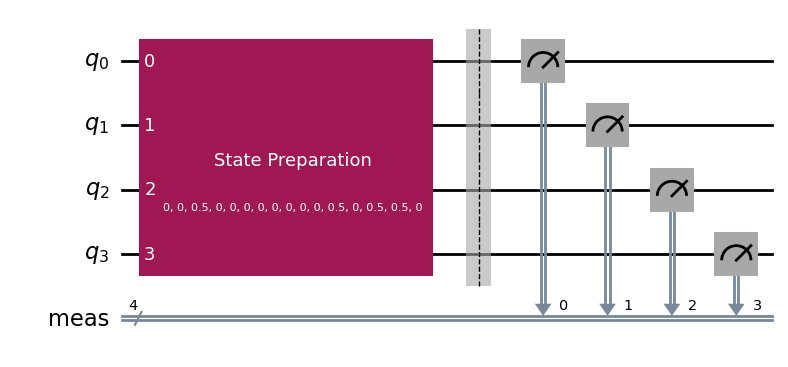

Combinatorial embeding


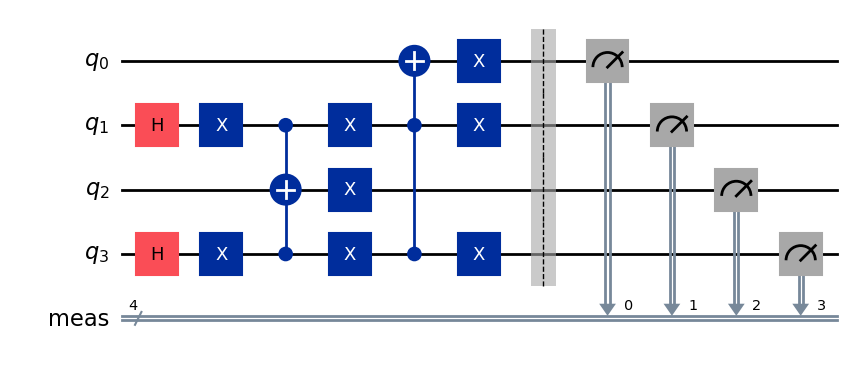

Möttönen embeding


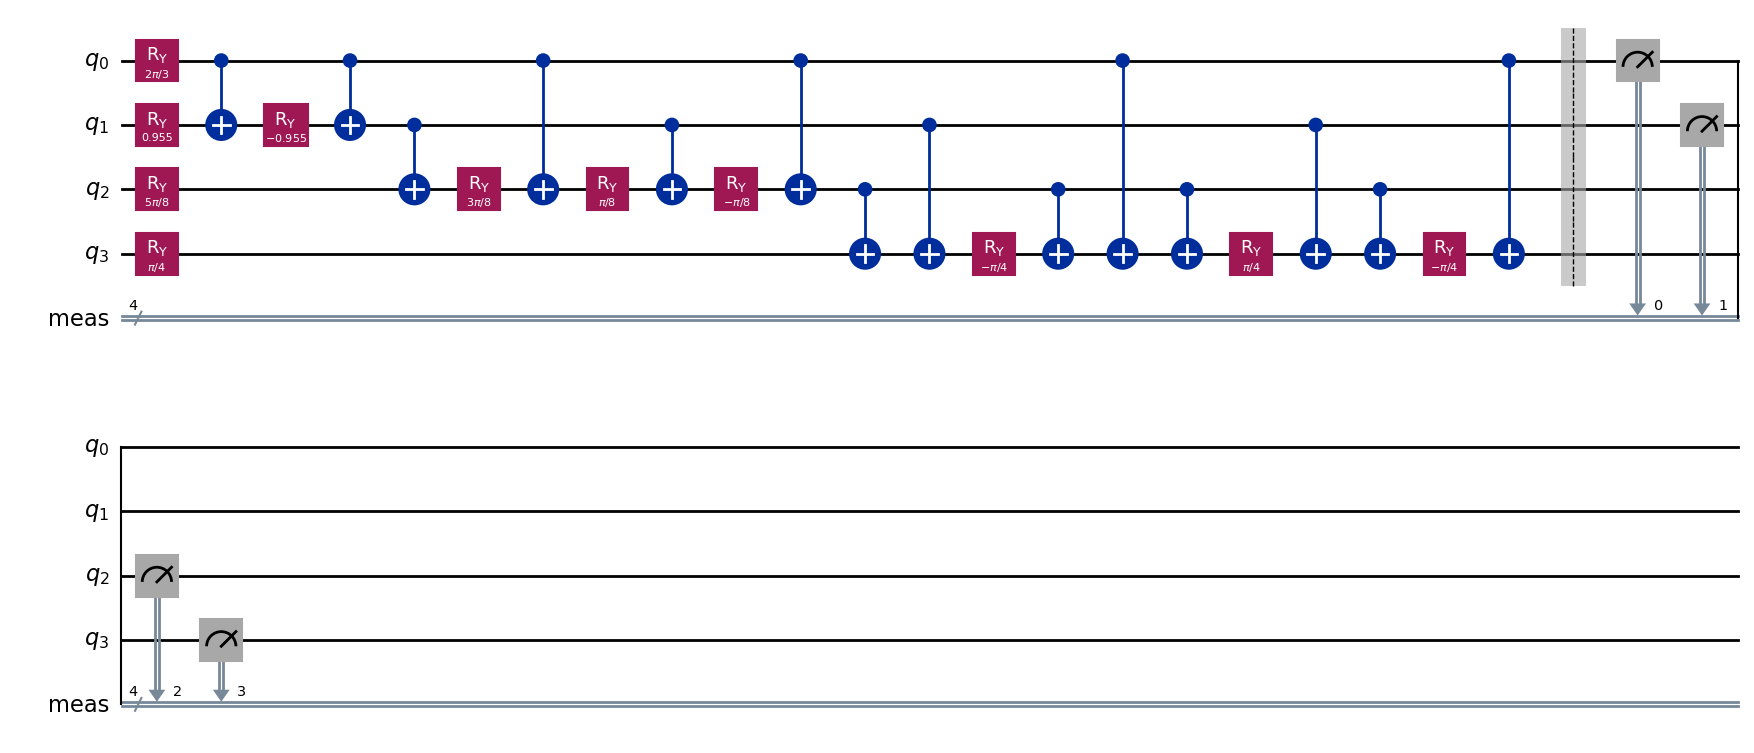

In [18]:
print('Isometry embeding')
display(embeding_dict['isom_circs'][nc].draw('mpl'))
print('Combinatorial embeding')
display(embeding_dict['comb_circs'][nc].draw('mpl'))
print('Möttönen embeding')
display(embeding_dict['mott_circs'][nc].draw('mpl'))

In [44]:
# device_gates = ['ECR', 'ID', 'RZ', 'SX', 'X']
# basis_gates = ["h", "ry", "cry", "cx", "ccx", "p", "cp", "x", "s", "sdg", "y", "t", "cz"]
# isom_circ = transpile(embeding_dict['isom_circs'][nc], basis_gates=basis_gates, optimization_level=2)
# isom_circ.draw('mpl')

Run jobs as a batch: https://docs.quantum.ibm.com/guides/run-jobs-batch

In [55]:
# # Partition large list of circuits into batches

# comb_partitioned_circs = []
# mott_partitioned_circs = []
# isom_partitioned_circs = []

# for i in range(0, len(test_list), max_circuits):
#     comb_partitioned_circs.append(embeding_dict['comb_circs'][i : i + max_circuits])
#     mott_partitioned_circs.append(embeding_dict['mott_circs'][i : i + max_circuits])
#     isom_partitioned_circs.append(embeding_dict['isom_circs'][i : i + max_circuits])

In [73]:
embeding_dict['comb_jobs'] = []
embeding_dict['mott_jobs'] = []
embeding_dict['isom_jobs'] = []

embeding_dict['comb_jobs_id'] = []
embeding_dict['mott_jobs_id'] = []
embeding_dict['isom_jobs_id'] = []

embeding_dict['comb_counts'] = []
embeding_dict['mott_counts'] = []
embeding_dict['isom_counts'] = []

embeding_dict['comb_fidelities'] = []
embeding_dict['mott_fidelities'] = []
embeding_dict['isom_fidelities'] = []

In [70]:
comb_transpiled_circs = []
mott_transpiled_circs = []
isom_transpiled_circs = []

# Transpile the circuit
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=device)

for i in tqdm(range(max_circuits)):
    comb_transpiled_circs.append(pass_manager.run(embeding_dict['comb_circs'][i]))
    mott_transpiled_circs.append(pass_manager.run(embeding_dict['mott_circs'][i]))
    isom_transpiled_circs.append(pass_manager.run(embeding_dict['isom_circs'][i]))


100%|██████████| 300/300 [01:03<00:00,  4.69it/s]


In [75]:
with Batch(backend=device) as ibm_batch:

    comb_job = device.run(comb_transpiled_circs)
    embeding_dict['comb_jobs'].append(comb_job)
    embeding_dict['comb_jobs_id'].append(comb_job.job_id())

    mott_job = device.run(mott_transpiled_circs)
    embeding_dict['mott_jobs'].append(mott_job) 
    embeding_dict['mott_jobs_id'].append(mott_job.job_id()) 

    isom_job = device.run(isom_transpiled_circs)
    embeding_dict['isom_jobs'].append(isom_job) 
    embeding_dict['isom_jobs_id'].append(isom_job.job_id()) 

In [76]:
def get_job_results(jobs_list, dict_file, key):
    for job in jobs_list:
        result = job.result()
        counts = result.get_counts()
        dict_file[key].append(counts)

In [81]:
get_job_results(embeding_dict['comb_jobs'], embeding_dict, 'comb_counts')
get_job_results(embeding_dict['mott_jobs'], embeding_dict, 'mott_counts')
get_job_results(embeding_dict['isom_jobs'], embeding_dict, 'isom_counts')

Confirmed: In the four qubit case, combinatorial circuit prepraration always uses fewer gates than Mottonen circuit preparation.

Code below : defining the library of counts of the 'ideal case' - corresponding to the prob. density function we should see. The counts will be simply 256 for each of the nonzero indices that appear in the input state vector, because there are 4 such indices, and we use 1024 shots.

In [88]:
def binary_positions(binary_list):
  result = []
  for i, bit in enumerate(binary_list):
    if bit == 1:
      binary_str = bin(i)[2:]  # Convert position to binary and remove "0b" prefix
      padded_str = binary_str.zfill(4)  # Pad with zeros to length 4
      result.append(padded_str)
  return result


def create_binary_dict(binary_expressions):
  #Note - using [::-1] here because the order of qubit listings is reversed. Not a problem though, this is just about labelling
  return {binary_str[::-1]: int(shots/4) for binary_str in binary_expressions}

ideal_counts = [create_binary_dict(binary_positions(vector)) for vector in test_list]

# Measuring the fidelities

We need to convert the shot counts to probabilities. Then we apply the formula for fidelities between prob. density functions of observed vs ideal.

The formula is given by $\sum_i \sqrt{p_i q_i}$ where $i$ ranges over all measurements, and $p_i$ and $q_i$ are the probabilities of observing that measurement in the ideal and observed case respectively.

In [ ]:
# counts_mottonen = [result.get_counts() for result in results_mottonen]
# counts_combinatorial = [result.get_counts() for result in results_combinatorial]

In [89]:
counts_mottonen = embeding_dict['mott_counts'][0]
counts_combinatorial = embeding_dict['comb_counts'][0]
counts_isometry = embeding_dict['isom_counts'][0]

In [90]:
probs_mottonen = [{string:count/shots for string,count in counts.items()} for counts in counts_mottonen]
probs_combinatorial = [{string:count/shots for string,count in counts.items()} for counts in counts_combinatorial]
probs_isometry = [{string:count/shots for string,count in counts.items()} for counts in counts_isometry]
probs_ideal = [{string:count/shots for string,count in counts.items()} for counts in ideal_counts]

In [91]:
def PDF_fidelity(probs_A, probs_B):

  common_bases_measured = list(probs_A.keys() & probs_B.keys())

  return np.sum([np.sqrt(probs_A[base] * probs_B[base]) for base in common_bases_measured])

In [92]:
fidelities_combinatorial = [PDF_fidelity(probs_ideal[i],probs_combinatorial[i]) for i in range(len(probs_combinatorial))]
fidelities_mottonen = [PDF_fidelity(probs_ideal[i],probs_mottonen[i]) for i in range(len(probs_mottonen))]
fidelities_isometry = [PDF_fidelity(probs_ideal[i],probs_isometry[i]) for i in range(len(probs_isometry))]
embeding_dict['comb_fidelities'] = fidelities_combinatorial
embeding_dict['mott_fidelities'] = fidelities_mottonen
embeding_dict['isom_fidelities'] = fidelities_isometry

In [94]:
print(np.mean(fidelities_combinatorial))
print(np.mean(fidelities_mottonen))
print(np.mean(fidelities_isometry))

0.9551421236328143
0.9527504845314035
0.4801282261443919


In [100]:

embeding_results = {}

embeding_results['comb_counts'] = counts_combinatorial
embeding_results['mott_counts'] = counts_mottonen
embeding_results['isom_counts'] = counts_isometry

embeding_results['comb_fidelities'] = fidelities_combinatorial
embeding_results['mott_fidelities'] = fidelities_mottonen
embeding_results['isom_fidelities'] = fidelities_isometry

In [101]:
# Open a file and use dump() to save dictionary
with open('zaiku_embeding.pkl', 'wb') as file: 
    # A new file will be created 
    pickle.dump(embeding_results, file, protocol=pickle.HIGHEST_PROTOCOL) 

In [ ]:
with open('zaiku_embeding.pkl', 'rb') as handle:
    results = pickle.load(handle)